## Kat pseudotime

In [1]:
import harmony
import palantir

# Plotting and miscellaneous imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Initialize random seed
import random
import numpy as np
random.seed(12345)
np.random.seed(12345)

%matplotlib inline

from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import scanpy as sc
import anndata
import subprocess

/opt/conda/envs/palantir-0.2.5/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
# !wget https://s3.amazonaws.com/dp-lab-data-public/mouse_endoderm/sc_endoderm_all_cells.h5ad -O data/sc_endoderm_all_cells.h5ad

In [3]:
dataset = sc.read('../data/raw/sc_endoderm_all_cells.h5ad')
metadata = pd.read_csv('../data/raw/e35_cell_types.csv', index_col=0)
dataset.obs.loc[metadata.index, 'CellType'] = metadata.CellType

In [4]:
adata = dataset[dataset.obs.Timepoint.isin(['E3.5', 'E4.5'])]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

# #Highly variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
# adata = adata[:, adata.var['highly_variable']]

/opt/conda/envs/palantir-0.2.5/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Harmony

In [5]:
data_df = adata[:, adata.var['highly_variable']].to_df()

<ipython-input-6-02dc4c0356a0>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tp = pd.Series(index=data_df.index)


Running PCA with 123 components
Nearest neighbor computation...
Constucting affinities between E3.5 and E4.5...
t+1 neighbors of t...
t neighbors of t+1...


100%|██████████| 500/500 [00:05<00:00, 87.57it/s]
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


BarnesHut Approximation  took  1.34  seconds
Repulsion forces  took  3.58  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.24  seconds
AdjustSpeedAndApplyForces step  took  0.28  seconds


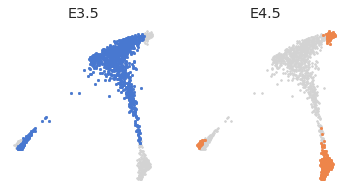

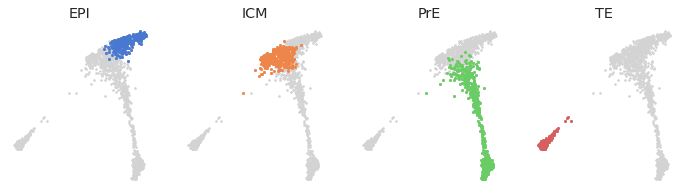

In [6]:
tp = pd.Series(index=data_df.index)
for t in ['E3.5', 'E4.5']:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t
    
timepoint_connections = pd.DataFrame(columns=[0, 1])
index = 0
timepoint_connections.loc[index, :] = ['E3.5', 'E4.5']; index += 1

aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, tp, timepoint_connections)
layout = harmony.plot.force_directed_layout(aug_aff, data_df.index)
harmony.plot.plot_timepoints(layout, tp)
harmony.plot.plot_timepoints(layout, adata.obs.CellType)

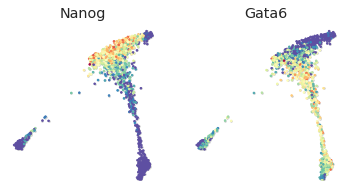

In [7]:
palantir.plot.plot_gene_expression(data_df, layout, ['Nanog', 'Gata6'])

### Pseudotime

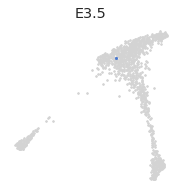

In [8]:
tmp = tp.sort_index(ascending=False)
# harmony.plot.plot_timepoints(layout, tmp.head(18))
harmony.plot.plot_timepoints(layout, tmp.iloc[[11]])

dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [9]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [10]:
# start_cell = 'kat-counts_Lib1-4_E3.5_TTGCGTCTCGTCGTTC'
start_cell = tmp.iloc[[11]].index[0]
pr_res = palantir.core.run_palantir(ms_data, start_cell, use_early_cell_as_start=True)

Sampling and flocking waypoints...
Time for determining waypoints: 0.003318345546722412 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.09347481727600097 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


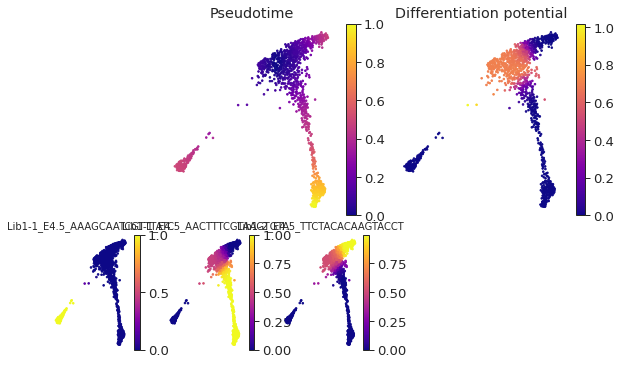

In [11]:
rcParams['figure.figsize'] = 15, 10
palantir.plot.plot_palantir_results(pr_res, layout)

## Imputation

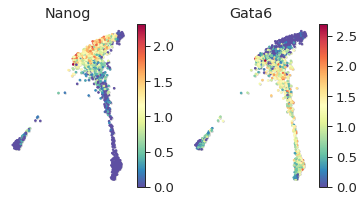

In [12]:
palantir.plot.plot_gene_expression(data_df, layout, ['Nanog', 'Gata6'], plot_scale=True)

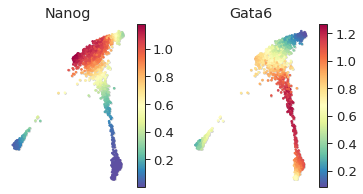

In [13]:
imp_df = palantir.utils.run_magic_imputation(data_df, dm_res)
palantir.plot.plot_gene_expression(imp_df, layout, ['Nanog', 'Gata6'], plot_scale=True)

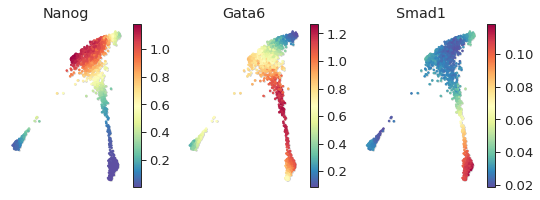

In [14]:
raw = adata.raw.to_adata().to_df()
count_imp_df = palantir.utils.run_magic_imputation(raw, dm_res)
palantir.plot.plot_gene_expression(count_imp_df, layout, ['Nanog', 'Gata6', 'Smad1'], plot_scale=True)

## Save as anndata

In [15]:
# smack stuff inside
adata.obs['pseudotime'] = pr_res.pseudotime
adata.layers['magic'] = count_imp_df
adata.obsm['X_tsne'] = np.array(layout)

In [16]:
adata.write('../data/processed/kat-replicated.h5')

In [1]:
!jupyter nbconvert --to html 01_analysis.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 01_analysis.ipynb to html
[NbConvertApp] Writing 861496 bytes to ../reports/01_analysis.html
